# Real-time $R_t$ computation on Italian COVID-19 data, by Stefano Terna$^1$

## Notebook on the computeation of $R_t$ by date of hospitalization

$^1$ PhD String Theory, [tomorrowdata.io](https://tomorrowdata.io) CEO

## Citations

1. Real Time Bayesian Estimation of the Epidemic Potential of Emerging Infectious Diseases, Luı´s M. A. Bettencourt, Ruy M. Ribeiro, [paper](https://journals.plos.org/plosone/article/file?id=10.1371/journal.pone.0002185&type=printable)
2. A New Framework and Software to Estimate Time-Varying Reproduction Numbers During Epidemics, Anne Cori, Neil M. Ferguson, Christophe Fraser, and Simon Cauchemez, [paper and supplementary data](https://academic.oup.com/aje/article/178/9/1505/89262)
3. Numero di riproduzione netto al tempo t, [Wikipedia](https://it.wikipedia.org/wiki/Numero_di_riproduzione_di_base#Numero_di_riproduzione_netto_al_tempo_t) 
4. FAQ sul calcolo del Rt, Istituto Superiore di Sanità, [link](https://www.iss.it/primo-piano/-/asset_publisher/o4oGR9qmvUz9/content/faq-sul-calcolo-del-rt)
5. Lockdown Can’t Last Forever. Here’s How to Lift It, Gabriel Leung, University of Hong Kong, [New York Times](https://www.nytimes.com/2020/04/06/opinion/coronavirus-end-social-distancing.html) 
6. Azienda sanitaria dell’Alto Adige, [Risultati](https://coronatest.sabes.it/it/muni) dello Screening a livello provinciale per il contenimento del Coronavirus
7. Task force COVID-19 del Dipartimento Malattie Infettive e Servizio di Informatica, Istituto Superiore di Sanità. Epidemia COVID-19, Aggiornamento nazionale: 18 novembre 2020
8. Tikhonov regularization, [Wikipedia](https://en.wikipedia.org/wiki/Tikhonov_regularization)
9. Task force COVID-19 del Dipartimento Malattie Infettive e Servizio di Informatica, Istituto Superiore di Sanità. Epidemia COVID-19, Aggiornamento nazionale: 18 agosto 2020
10. Dati COVID-19 Italia, Protezione Civile, [github](https://github.com/pcm-dpc/COVID-19)

In [1]:
import json
import warnings
import os
from PIL import Image

from datetime import datetime, date, timedelta
from pytz import timezone
from numbers import Number

import pandas as pd
import numpy as np

from matplotlib import pyplot as plt, dates as mdates, cbook, image 
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle

# credits and installation https://github.com/njchiang/tikhonov.git
from sklearn.linear_model import LinearRegression
from tikhonov.TikhonovRegression import Tikhonov

from scipy import stats

# Markov chain Monte Carlo
import arviz as az
import pymc3 as pm
import theano.tensor as tt
import theano

warnings.simplefilter(action="ignore", category=(FutureWarning,UserWarning))

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


#### set to `True` to update the files with the results:

In [2]:
UPDATE_RESULTS = True

In [3]:
BASE_DATA_PATH = '../../data'
BASE_IMAGES_PATH = '../../images'

In [4]:
SAVE_IMAGE_PATH=None
if UPDATE_RESULTS:
    SAVE_IMAGE_PATH=os.path.join(
        BASE_IMAGES_PATH, 'TD_Rt_computation_new_hospitalized_MCMC_300dpi.{}'
    )

In [5]:
def make_error_boxes(ax, ydata, xerror, yerror, facecolor='r',
                     edgecolor='None', alpha=0.5):

    # Create list for all the error patches
    errorboxes = []

    # Loop over data points; create box from errors at each point
    xerror = mdates.date2num(xerror)
    for y, xe, ye in zip(ydata, xerror.T, yerror.T):        
        rect = Rectangle((xe[0], y - ye[0]), xe[1]-xe[0], ye.sum())
        errorboxes.append(rect)

    # Create patch collection with specified colour/alpha
    pc = PatchCollection(errorboxes, facecolor=facecolor, alpha=alpha,
                         edgecolor=edgecolor)

    # Add collection to axes
    ax.add_collection(pc)

In [6]:
def plot_series(title, df=None, yfields=None, data=None, xfield='data', ylim=None, xlim=None, path=None, dpi=300, legendloc='upper left'):

    if data is None and df is not None:
        data=[{}]
        data[0]['df'] = df
        data[0]['yfields'] = yfields
        data[0]['labels'] = yfields
        
    fig, ax1 = plt.subplots(figsize=(30,15))
    ax1.set_title(title, fontsize=30)
    ax1.tick_params(axis='both', labelsize=27)    
    ax1.tick_params(axis='x', labelrotation=45)

    ax1.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=mdates.WE))
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%d %b'))
    ax1.xaxis.set_tick_params(width=5)
    ax1.yaxis.set_tick_params(width=5)
    ax1.grid()    
    
    if ylim:
        ax1.set_ylim(*ylim)
    if xlim:
        ax1.set_xlim(*xlim)

    for d in data:
        df = d['df']
        yfields = d['yfields']
        if 'labels' in d:
            labels = d['labels']
        else:
            labels = yfields
            
        for f in yfields:
            dates = df[xfield].dt.normalize()
            ax1.plot(
                dates, 
                df[f], 
                label=labels[yfields.index(f)], 
                linestyle=':', marker='o'
            )

    _ = ax1.legend(fontsize=27, loc=legendloc)   
    if path:
        plt.savefig(path.format('png'), dpi=dpi)

        im = Image.open(path.format('png'))
        rgb_im = im.convert('RGB')
        rgb_im.save(path.format('jpg'))

In [7]:
def plot_MCMC_sampling(df, column, ISS_df, ylim=(0,3), xlim=None, average=True, std=True, conf_int=False, path=None, dpi=None, title=''):
            
    fig, ax1 = plt.subplots(figsize=(30,15))
    ax1.set_title(title, fontsize=30)
    ax1.tick_params(axis='both', labelsize=27)
    ax1.tick_params(axis='x', labelrotation=45)

    ax1.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=mdates.WE))
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%d %b'))
    ax1.xaxis.set_tick_params(width=5)
    ax1.yaxis.set_tick_params(width=5)
    ax1.grid()    

    updatemessage = 'Aggiornamento del {}'.format(df.data.max().strftime('%d %b %Y'))
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)    
    ax1.text(0.65, 0.97, updatemessage, transform=ax1.transAxes, fontsize=24,
            verticalalignment='top', bbox=props)    
    
    ax1.set_ylim(*ylim)
    if xlim:
        ax1.set_xlim(*xlim)

    ISS_time_ranges = ISS_df.loc[:,['computation_time_range_start','computation_time_range_end']].to_numpy().T
    make_error_boxes(
        ax=ax1,
        ydata=ISS_df.Rt, 
        xerror=ISS_time_ranges,
        yerror=ISS_df.loc[:,['Rt_95_err_min','Rt_95_err_max']].to_numpy().T,
        facecolor='dodgerblue', alpha=0.15
    )
        
    date = df['data'].dt.normalize()
    ax1.plot(
        date, 
        df['{}_Rt_MCMC'.format(column)], 
        label='Stima di $R_t$ sul valore dei $nuovi\_ospedalizzati$ giornalieri, calcolati su dati Protezione Civile',
        marker='o', color = 'green'
    )

    if conf_int:
        ax1.fill_between(
            date, 
            df['{}_Rt_MCMC_CI_95_min'.format(column)],
            df['{}_Rt_MCMC_CI_95_max'.format(column)],
            color='orange', alpha=.3,
            label="95% confidence interval"
        )

    ax1.fill_between(
        date, 
        df['{}_Rt_MCMC_HDI_95_min'.format(column)],
        df['{}_Rt_MCMC_HDI_95_max'.format(column)],
        color='green', alpha=.3, 
        label = '95% credible interval'
    )

    if average:
        ax1.plot(
            date, 
            df['{}_Rt_MCMC_avg14'.format(column)], 
            label='Avg14 Rt MCMC Estimate - {}'.format(column),
            marker='o', color = 'green'
        )    

    if std:
        ax1.fill_between(
            date, 
            df['{}_Rt_MCMC_CI_95_14_min'.format(column)],
            df['{}_Rt_MCMC_CI_95_14_max'.format(column)],
            color='blue', alpha=.25,
            label="95% confidence interval on 14 days average"
        )
    
    
    refdates = np.mean(mdates.date2num(ISS_time_ranges), axis=0)
    xerr = np.abs(refdates - mdates.date2num(ISS_time_ranges))
    ax1.errorbar(
        np.mean(mdates.date2num(ISS_time_ranges), axis=0), 
        ISS_df.Rt, 
        #xerr=xerr,
        yerr=ISS_df.loc[:,['Rt_95_err_min','Rt_95_err_max']].to_numpy().T,
        #uplims=True, lolims=True,
        label='Stima di $R_t$ pubblicata dall\'Istituto Superiore di Sanità, con range di possibile variazione nel periodo',
        marker='o', color = 'blue', linestyle=':', ecolor='dodgerblue'
    )
    
    _ = ax1.legend(fontsize=27, loc='lower right')
    
    if path:
        plt.savefig(path.format('png'), dpi=dpi)

        im = Image.open(path.format('png'))
        rgb_im = im.convert('RGB')
        rgb_im.save(path.format('jpg'), optimize=True, quality=60)

# Two data sources

We have two official data sources:

- ISS data (Istituto Superiore della Sanita')
- pcm-dpc data (Protezione Civile)

See https://www.epicentro.iss.it/coronavirus/sars-cov-2-sorveglianza , at "Perché le informazioni fornite dall’ISS possono differire (essere in ritardo) rispetto a quelle della Protezione civile"


## ISS data (Istituto Superiore della Sanita')

These data are available via the Ministero della Sanita' web site, not in their raw format, but only via descriptive reports.

To obtain the data  one needs to navigate (or scrape) the intricated and non standardized structure of the weekly reports from ministero della Sanita'

What follows is the result of the scraping, aimed to obtain the $Rt$ values computed by ISS.

In the "url" column the url to the official report is reported.

To update the ISS dataset, check manuallty [here](http://www.salute.gov.it/portale/nuovocoronavirus/archivioNotizieNuovoCoronavirus.jsp?lingua=italiano&tipo=Report+settimanale+Covid-19&btnCerca=cerca) for new weekly updates.

In [8]:
ISS_Rt = pd.read_csv(
    os.path.join(BASE_DATA_PATH, 'sources/Rt_from_ISS.csv'),
    parse_dates=['computation_time_range_start', 'computation_time_range_end']
)

In [9]:
ISS_Rt.head()

,ID,report_time_range_descr,computation_time_range_descr,computation_time_range_start,computation_time_range_end,Rt,Rt_95_min,Rt_95_max,Rt_text,report_data,notes,source,source_detail,url,link
0,5474,26/4/2021-2/5/2021,14 – 27 aprile 2021,2021-04-14,2021-04-27,0.89,0.85,0.91,"0,89 (range 0,85– 0,91)",5 maggio 2021,NaN,attachement,NaN,https://www.iss.it/documents/20126/0/Monitorag...,5 maggio 2021
1,5465,19/4/2021-25/4/2021,7 – 20 aprile 2021,2021-04-07,2021-04-20,0.85,0.80,0.91,"0,85 (range 0,80– 0,91)",28 aprile 2021,NaN,attachement,NaN,https://www.iss.it/documents/20126/0/Monitorag...,28 aprile 2021
2,5442,12/4/2021-18/4/2021,31 marzo – 13 aprile 2021,2021-03-31,2021-04-13,0.81,0.77,0.89,"0,81 (range 0,77– 0,89)",21 aprile 2021,NaN,attachement,NaN,https://www.iss.it/documents/20126/0/Monitorag...,21 aprile 2021
3,5432,5/4/2021-11/4/2021,24 marzo – 06 aprile 2021,2021-03-24,2021-04-06,0.85,0.71,0.97,"0,85 (range 0,71– 0,97)",14 aprile 2021,NaN,attachement,NaN,https://www.iss.it/documents/20126/0/Monitorag...,14 aprile 2021
4,5421,29/3/2021-4/4/2021,17 – 30 marzo 2021,2021-03-17,2021-03-30,0.92,0.82,1.01,"0,92 (range 0,82– 1,01)",7 aprile 2021,NaN,attachement,NaN,http://www.salute.gov.it/imgs/C_17_monitoraggi...,7 aprile 2021


In [10]:
ISS_Rt_clean = ISS_Rt.loc[:,[
    'computation_time_range_start','computation_time_range_end','Rt','Rt_95_min','Rt_95_max'
]].dropna()

In [11]:
ISS_Rt_clean['Rt_95_err_max'] = ISS_Rt_clean.Rt_95_max - ISS_Rt_clean.Rt
ISS_Rt_clean['Rt_95_err_min'] = ISS_Rt_clean.Rt - ISS_Rt_clean.Rt_95_min

In [12]:
ISS_Rt_clean['Rt_reference_date'] = (
    (
        ISS_Rt_clean.computation_time_range_start + 
        (ISS_Rt_clean.computation_time_range_end - ISS_Rt_clean.computation_time_range_start)/2
    ).dt.normalize()+timedelta(days=1, minutes=-1)
)
ISS_Rt_clean.sort_values(by='Rt_reference_date', inplace=True)
ISS_Rt_clean.reset_index(inplace=True, drop=True)

In [13]:
ISS_Rt_clean.tail()

,computation_time_range_start,computation_time_range_end,Rt,Rt_95_min,Rt_95_max,Rt_95_err_max,Rt_95_err_min,Rt_reference_date
34,2021-03-17,2021-03-30,0.92,0.82,1.01,0.09,0.10,2021-03-23 23:59:00
35,2021-03-24,2021-04-06,0.85,0.71,0.97,0.12,0.14,2021-03-30 23:59:00
36,2021-03-31,2021-04-13,0.81,0.77,0.89,0.08,0.04,2021-04-06 23:59:00
37,2021-04-07,2021-04-20,0.85,0.80,0.91,0.06,0.05,2021-04-13 23:59:00
38,2021-04-14,2021-04-27,0.89,0.85,0.91,0.02,0.04,2021-04-20 23:59:00


# pcm-dpc data (Protezione Civile)

In [14]:
def parse_date_pcm(date):
    return datetime.strptime(date[:10] + ' 23:59:00', '%Y-%m-%d %H:%M:%S')

In [15]:
italy_raw_data = pd.read_csv(
    'https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-andamento-nazionale/dpc-covid19-ita-andamento-nazionale.csv',
    parse_dates=['data'],
    date_parser=parse_date_pcm
)

In [16]:
italy_raw_data.columns

Index(['data', 'stato', 'ricoverati_con_sintomi', 'terapia_intensiva',
       'totale_ospedalizzati', 'isolamento_domiciliare', 'totale_positivi',
       'variazione_totale_positivi', 'nuovi_positivi', 'dimessi_guariti',
       'deceduti', 'casi_da_sospetto_diagnostico', 'casi_da_screening',
       'totale_casi', 'tamponi', 'casi_testati', 'note',
       'ingressi_terapia_intensiva', 'note_test', 'note_casi',
       'totale_positivi_test_molecolare',
       'totale_positivi_test_antigenico_rapido', 'tamponi_test_molecolare',
       'tamponi_test_antigenico_rapido'],
      dtype='object')

In [17]:
TIMESTEPS = len(italy_raw_data.nuovi_positivi)

# Fix NaN data

`casi_da_sospetto_diagnostico` and `casi_da_screening` have been measured only after a certain date

In [18]:
FIRST_CASI_SOSP_DIAGNOSTICO = italy_raw_data.casi_da_sospetto_diagnostico.first_valid_index()
italy_raw_data.loc[FIRST_CASI_SOSP_DIAGNOSTICO,['data']]

data    2020-06-25 23:59:00
Name: 122, dtype: object

In [19]:
italy_raw_data.loc[italy_raw_data.casi_da_screening.first_valid_index(),['data']]

data    2020-06-25 23:59:00
Name: 122, dtype: object

In [20]:
italy_raw_data.casi_da_sospetto_diagnostico.fillna(0, inplace=True)
italy_raw_data.casi_da_screening.fillna(0, inplace=True)

# Compute new cases

In [21]:
italy_raw_data['nuovi_casi_da_sospetto_diagnostico'] = \
    (italy_raw_data.casi_da_sospetto_diagnostico -
     italy_raw_data.casi_da_sospetto_diagnostico.shift(1)).fillna(0)

In [22]:
italy_raw_data['nuovi_casi_da_screening'] = \
    (italy_raw_data.casi_da_screening -
     italy_raw_data.casi_da_screening.shift(1)).fillna(0)

# Smoothing data via Tikhonov regularization

## Function `smooth_data`

Data are smoothed by fitting a series to represent the derivative of the original signal and then integrating it back to the original signal, which results in a smoothed one.


Given $y$ the signal to be smoothed, we search for the differential signal $\omega$ such that:
$$y = X\cdot \omega$$
where $X$ is the matrix representing the integration operator:
$$X = \begin{bmatrix} 
1 & 0 & 0 & ... & 0 \\
1 & 1 & 0 & ... & 0 \\
1 & 1 & 1 & ... & 0 \\
... & ... & ... & ...  & ... \\
1 & 1 & ... & ... & 1 \\
\end{bmatrix}
$$

$\omega$ is obtained by minimizing the following cost function:
$$F(\omega) = \left\|y - X\cdot\omega\right\|^2 +\alpha^2 \left\|\Gamma\cdot\omega\right\|^2$$

Hence the derivative is fitted using a Ridge regresssion with a generalized Tikhonov regularization factor:
- $y$: the original signal
- $X$: we choose the the integration matrix, to force the fitted signal to be the derivative one
- $\Gamma$: the Tikhonov regularizaztion matrix, choosen as the second derivative operator
- $\alpha$: the regularization factor

The regularization factor penalizes the noise, forcing the derivative to be a smoothed signal.
Once the derivative is fitted, then the original signal is reconstructed by appliyng again the integral matrix to the differentiated signal. The bigger the alpha factor, the smoother the signal.

## Function `smooth_differentiate`
As a byproduct of this procedure, we can apply the fit to cumulative data to obtain the daily variations, eg to obtain the "nuovi_positivi" from the "totale_casi"

## Function `filter_matrices`
Integral and derivative matrices are just the matrices that applyed to a signal produce the integral or the derivative. They are built via `np.tri`, `np.ones` and `np.eye`.


In [23]:
def filter_matrices(timesteps):
    
    integral_matrix = np.tri(timesteps,timesteps,0)

    derivative_matrix = np.eye(timesteps,timesteps)-(np.tri(timesteps,timesteps,-1)-np.tri(timesteps,timesteps,-2))

    second_derivative_matrix = np.dot(derivative_matrix, derivative_matrix)
    
    return integral_matrix, second_derivative_matrix 


In [24]:
ALPHA = 100.

INTEGRAL_MATRIX, SECOND_DERIVATIVE_MATRIX = filter_matrices(TIMESTEPS)

GAMMA = SECOND_DERIVATIVE_MATRIX

In [25]:
def smooth_data(y, X, L, alpha, verbose=True):    
    tic = Tikhonov(alpha=alpha)
    tic.fit(y=y, X=X, L=L)
    if verbose:
        print('TIC R2: {}'.format(tic.score(X=X, y=y)))
    
    return tic.predict(X)

def smooth_differentiate(y, X, L, alpha, verbose=True):
    tic = Tikhonov(alpha=alpha)
    tic.fit(y=y, X=X, L=L)
    if verbose:
        print('TIC R2: {}'.format(tic.score(X=X, y=y)))
    
    return tic.coef_

## Alternative to fitting, the analytic solution

$${\displaystyle {\hat {x}}=(A^{\top }A+\Gamma ^{\top }\Gamma )^{-1}A^{\top }\mathbf {b} }$$

In [26]:
def get_Tikhonov_matrix(steps, alpha):
    X, G = filter_matrices(steps)
    
    return np.dot(
        np.linalg.inv(
            np.dot(X.T, X) + np.dot(alpha * G.T, alpha * G)
        ), 
        X.T
    )

# Compute $R_t$

Definitions and parameters values are form Ref: https://www.iss.it/primo-piano/-/asset_publisher/o4oGR9qmvUz9/content/faq-sul-calcolo-del-rt

$R_t$ si defined as:

$$\large{R_t = \frac{I_t}{\sum_{s=1}^t w_s I_{t-s}}}$$

Where:
- $I_t$ is `nuovi_positivi` at day t, or any first difference of a cumulative value
- $w_s=\Gamma(s; \alpha,\beta)$, [the Gamma distribution](https://en.wikipedia.org/wiki/Gamma_distribution)
- $\alpha = 1.87$
- $\beta = 0.28$

In [27]:
def gamma_df(x, alpha, beta):
    return stats.gamma.pdf(x, a=alpha, scale=1/beta)

In [28]:
def gamma_pf(x, alpha, beta):
    return stats.gamma.ppf(x, a=alpha, scale=1/beta)

In [29]:
def infectious_charge(series, alpha, beta):
    steps = len(series)
    x = np.linspace(1,steps-1, steps)
    w = gamma_df(x, alpha, beta)
    
    infectious_charge_ = [np.nan] + [
        sum(series[t-1::-1]*w[:t]) 
        for t in range(1, steps)        
    ]
    
    return np.asarray(infectious_charge_)

In [30]:
def Rt(series, alpha, beta):
    infectious_charge_ = infectious_charge(series, alpha, beta)
    
    return series / infectious_charge_

# Estimating $R_t$ with Markov chain Monte Carlo

In [31]:
def pad_window(a, start, window=None):
    if not window:
        window = 0
    
    return np.pad(
        a,
        [(start+1,window)] + [(0,0)]*(len(a.shape)-1), 
        mode='constant', 
        constant_values=np.nan
    )

def save_MCMC_sampling(df, column, trace, interval=0.95, start=0, window=None):
    interval_frac = int(interval*100)
    sampling_mean = np.mean(trace['r_t'], axis=0)

    df['{}_Rt_MCMC'.format(column)] = pad_window(sampling_mean, start, window)
    
    df['{}_Rt_MCMC_avg14'.format(column)] = df['{}_Rt_MCMC'.format(column)].rolling(
        window=14, center=True
    ).mean()
    
    # confidence interval 14
    conf_int_14 = stats.norm.interval(
        interval, 
        df['{}_Rt_MCMC_avg14'.format(column)],
        df['{}_Rt_MCMC'.format(column)].rolling(
                window=14, center=True
        ).std()
    )
    
    df['{}_Rt_MCMC_CI_{}_14_min'.format(column, interval_frac)] = conf_int_14[0]
    df['{}_Rt_MCMC_CI_{}_14_max'.format(column, interval_frac)] = conf_int_14[1]

    #credible interval
    sampling_hdi = pad_window(
        pm.stats.hpd(trace['r_t'], hdi_prob=interval), 
        start, window
    )


    df['{}_Rt_MCMC_HDI_{}_min'.format(column, interval_frac)] = sampling_hdi[:,0]
    df['{}_Rt_MCMC_HDI_{}_max'.format(column, interval_frac)] = sampling_hdi[:,1]

    # confidence interval
    conf_int = stats.norm.interval(
        interval, 
        sampling_mean,
        np.std(trace['r_t'], axis=0)
    )

    df['{}_Rt_MCMC_CI_{}_min'.format(column, interval_frac)] = pad_window(conf_int[0], start, window)
    df['{}_Rt_MCMC_CI_{}_max'.format(column, interval_frac)] = pad_window(conf_int[1], start, window)
    
    

In [32]:
def MCMC_sample(
    onset, 
    alpha, 
    beta, 
    start=0, window=None, 
    chains=1, tune=4000, draws=4000, 
    target_accept=0.95, 
    dry=False, 
    cores=None,
    progressbar=True
):

    if not window:
        window = len(onset)
        
    if type(onset)==pd.DataFrame:
        onset = onset.values
        
    onset_ = onset[start:start+window]
    
    with pm.Model() as model:
                
        # draws R_t from a prior normal distribution
        r_t = pm.Normal("r_t", mu=1.3, sigma=10., shape=len(onset_)-1)

        # compute the exptect number of current infectious 
        # based on the sampled R_t and the know past values of infectious
        infectious_charge_ = infectious_charge(onset_, alpha, beta)[1:]
        expected_today = r_t * infectious_charge_
        
        # Poisson requirements
        mu = pm.math.maximum(.1, expected_today)        
        observed = (onset_[1:]).round()

        # test the posterior: 
        # mu values derived from R_t samples 
        # must converge to the mean of real cases 
        # if they are Poisson distributed, as they are
        cases = pm.Poisson('cases', mu=mu, observed=observed)

        trace = None
        if not dry:
            trace = pm.sample(
                chains=chains,
                cores=cores,
                tune=tune,
                draws=draws,
                target_accept=target_accept,
                progressbar=progressbar)
        
            #assert not trace.diverging.any()
    
    return model, trace

# Taking into account the uncertainty on tomorrow, propagating it back to past days, up to today

So, we know the cumulative value `totale_casi` up to today, but we do not know it as of tomorrow, pretty obvious :)

While smoothing the series via Tikhonov, the uncertainty on the next future value of `totale_casi` can reflect in the fitting, altering the trend of the fit of the last known values of the series.

To take into account this uncertainty we adopt the following 3-step procedure.

## 1. randomly sample lots of tomorrow values (so called TomorrowData)

We make just one hypothesys on this future values:

- that they are normally distributed random value ranging from the same value of today up to the value that we obtain doubling the average increment of the past week. **We average the increment over one week** to exclude the seasonal weekly artifacts, like the typical drop in Monday numbers. Please note that averaging the uncertainty about tomorrow is really different than averaging the end result over one (or two) weeks, just to smooth out the noise.

Technically, the random value is drawn from a zero truncated normal distribution, truncated to prevent the cumulative value to decrease, in case negative increments are drawn from the distribution.

We can't really imagine a bigger "ignorance" about the future, then stating that the new cases of tomorrow can range from 0 to twice the (average) cases of tomorrow.

## 2. generate lots of possible series, each ending with one of the sampled tomorrow values

We simply replicate the series of `totale_casi` known up to today, for how many time as the quantity of random tomorrow values we sampled in step 1.
Then we append the random value at the end of each replicated series.

## 3. apply Tikhonov to each of the generated series

Each possible future will be accounted for by Tikhonov, by distorting the most recent smoothed points, as the regularization tries to minimize the error of the fit, and we included the random value as the last point.

After computing all of the smoothing, we drop the last value value from each of them as it is the meaningless randomly guessed future. 

We end up with lots of smoothed signals, which have slightly different trends on the most recend day. **This differences encode our uncertainty about the future.**

## Tech note

We actually need to compute the `nuovi_casi` which are the differences of `totale_casi`, as the ultimate goal is to compute the $R_t$. 

For this purpose we use the function `smooth_differentiate` which fits the derivative of the signal, without recomputing back the integral.

In [33]:
def get_differences_with_uncenrtainty_from_future(
    s, alpha, beta, future_distribution='normal',
    tune=5000, draws=25, chains=4, target_accept=0.95):

    week = 7
    s_week_shift = s.shift(week).values
    s = s.values
    
    # s is the cumulative series about `totale_casi` 
    # that we know up to today, but we do not know as of tomorrow
    # 
    # While smoothing the series via Tikhonov,
    # the uncertainty on the next future value of s 
    # can reflect in the fitting 
    # altering the trend of the fit
    # of the last known values of the series

    # here we make just one hypothesys: 
    # that the next future value in the series can be a random value 
    # ranging from the same value as today
    # up to the value we obtain doubling the increment from yesterday to today
    # which turns out to be `nuovi_positivi` of today
    
    # the random value is drawn from a uniform or a truncated normal distribution
    # based on the `future_distribution` parameter

    # the increment from yesterday to today:
    today_value = s[-1]
    
    # the increment is computed as average increment over one week to get rid of the seasonal component
    today_increment = (today_value - s_week_shift[-1])[0]/week
    print(today_increment)
        
    with pm.Model() as model:

        # draw the first future unkonwn value as the last known values + a uniform derivative
        
        #gaussian derivative:
        #derivative  = pm.TruncatedNormal('last_diff', mu=diff, sigma=diff, lower=0)
        
        #uniform derivative:
        if future_distribution == 'uniform':
            derivative = pm.Uniform('derivative', lower=0, upper=2.*today_increment)
        elif future_distribution == 'normal':
            derivative  = pm.TruncatedNormal('derivative', 
                                             mu=today_increment, sigma=today_increment, lower=0, upper=2.*today_increment)
        else:
            raise Exception("future distribution {} not supported. Supported distributions are `uniform` or `normal`")
            
        first_future_value = pm.Deterministic('first_future_value', today_value + derivative)

        trace_ = pm.sample(tune=tune, draws=draws, chains=chains, target_accept=target_accept)

    possible_future_values = trace_['first_future_value']
        
    # create `draws*chains` replicas of the series:
    possible_series = np.repeat(s.reshape((1,len(s))), draws*chains, axis=0)
    #expand the possibile_series to append the uncertain value at the end of each history
    possible_series = np.append(possible_series, possible_future_values.reshape((draws*chains,1)), axis=1)

    # apply Tikhonov in the form of `smooth_differentiate` 
    # to the whole `possibile_series` including the first future value
    # to obtain all the possible curve dei contagi, 
    # propagating our uncertainty back from the future
    
    TIKHONOV_MATRIX = get_Tikhonov_matrix(len(s)+1, 10.)
    possibile_smoothed_series = np.empty(possible_series.shape)
    possible_Rt_series = np.empty(possible_series.shape)
    for i in range(possible_series.shape[0]):
        possibile_smoothed_series[i] = np.dot(TIKHONOV_MATRIX, possible_series[i])

        # comupute all the possible Rt values
        possible_Rt_series[i] = Rt(possibile_smoothed_series[i], alpha, beta)
        
        
    
    # drop the last value as it is the meaningless randomly guessed future
    return (possibile_smoothed_series[:,:-1], possible_Rt_series[:,:-1])

In [34]:
def get_differences_mean_and_conf_int(s, conf_int=0.95):
    mean = np.mean(s, axis=0)
    std = np.std(s, axis=0)
    interval = stats.norm.interval(
        conf_int, 
        mean,
        std
    )
    mean = np.expand_dims(mean, axis=1)
    interval_min = np.expand_dims(interval[0], axis=1)
    interval_max = np.expand_dims(interval[1], axis=1)
    std = np.expand_dims(std, axis=1)
    return np.concatenate([mean, interval_min, interval_max, std], axis=1)


In [35]:
def compute_and_store_differences_with_uncertainty(
    df, cumulative_in, difference_out, alpha, beta, stop_before = 0,
    future_distribution = 'normal', tune=15000, draws=100, target_accept=0.999, chains=4):
    
    used_values_from_beginning = df.shape[0] - stop_before
    
    possibile_smoothed_differences, possible_rt_series = get_differences_with_uncenrtainty_from_future(
        df.iloc[:used_values_from_beginning, df.columns==cumulative_in], alpha, beta,
        future_distribution = future_distribution, tune=tune, draws=draws, 
        target_accept=target_accept, chains=chains
    )
    print('possibile_smoothed_differences: {}'.format(possibile_smoothed_differences.shape))
    diffs_mean_conf_int = np.pad(
        array=get_differences_mean_and_conf_int(possibile_smoothed_differences, conf_int=0.95),
        pad_width=((0,stop_before),(0,0)), mode='constant', constant_values=((0,np.nan),(0,0)))
    
    rt_mean_conf_int = np.pad(
        array=get_differences_mean_and_conf_int(possible_rt_series, conf_int=0.95),
        pad_width=((0,stop_before),(0,0)), mode='constant', constant_values=((0,np.nan),(0,0)))
    
    df['{}'.format(difference_out)] = diffs_mean_conf_int[:,0]
    df['{}_95CI_min'.format(difference_out)] = diffs_mean_conf_int[:,1]
    df['{}_95CI_max'.format(difference_out)] = diffs_mean_conf_int[:,2]
    df['{}_std'.format(difference_out)] = diffs_mean_conf_int[:,3]
    
    df['{}_Rt_Naive'.format(difference_out)] = rt_mean_conf_int[:,0]
    df['{}_Rt_Naive_95CI_min'.format(difference_out)] = rt_mean_conf_int[:,1]
    df['{}_Rt_Naive_95CI_max'.format(difference_out)] = rt_mean_conf_int[:,2]
    df['{}_Rt_Naive_std'.format(difference_out)] = rt_mean_conf_int[:,3]
    
    return possibile_smoothed_differences

In [36]:
def plot_differences_with_uncertainty(df, difference_field, smoothed_default='nuovi_positivi_smoothed', ylim=None, xlim=None, path=None, dpi=None):
            
    fig, ax1 = plt.subplots(figsize=(30,15))
    ax1.set_title('', fontsize=30)
    ax1.tick_params(axis='both', labelsize=27)
    ax1.tick_params(axis='x', labelrotation=45)

    ax1.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=mdates.WE))
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%d %b'))
    ax1.xaxis.set_tick_params(width=5)
    ax1.yaxis.set_tick_params(width=5)
    ax1.grid()    

    update_date = df.data[df[difference_field].last_valid_index()]
    
    updatemessage = 'Aggiornamento del {}'.format(update_date.strftime('%d %b %Y'))
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)    
    ax1.text(0.65, 0.97, updatemessage, transform=ax1.transAxes, fontsize=24,
            verticalalignment='top', bbox=props)    
    
    if ylim:
        ax1.set_ylim(*ylim)
    if xlim:
        ax1.set_xlim(*xlim)
        
    date= df['data'].dt.normalize()
    ax1.plot(
        date, 
        df['nuovi_positivi'], 
        label='nuovi_positivi',
        marker='o', color = 'blue'
    )
    
    if smoothed_default:
        ax1.plot(
            date, 
            df[smoothed_default], 
            label='nuovi_positivi_smoothed',
            marker='o', color = 'red'
        )
    ax1.plot(
        date, 
        df[difference_field],
        label='nuovi_positivi smoothed with Tikhonov',
        marker='o', color = 'green'
    )

    ax1.fill_between(
        date, 
        df['{}_95CI_min'.format(difference_field)],
        df['{}_95CI_max'.format(difference_field)],
        color='green', alpha=.3,
        label="nuovi_positivi_smoothed 95% confidence interval"
    )

    _ = ax1.legend(fontsize=27, loc='lower right')
    
    if path:
        plt.savefig(path.format('png'), dpi=dpi)

        im = Image.open(path.format('png'))
        rgb_im = im.convert('RGB')
        rgb_im.save(path.format('jpg'), optimize=True,quality=60)

In [37]:
def plot_Rt_with_uncertainty(df, Rt_field, smoothed_default='nuovi_positivi_smoothed', ylim=None, xlim=None, path=None, dpi=None):
            
    fig, ax1 = plt.subplots(figsize=(30,15))
    ax1.set_title('', fontsize=30)
    ax1.tick_params(axis='both', labelsize=27)
    ax1.tick_params(axis='x', labelrotation=45)

    ax1.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=mdates.WE))
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%d %b'))
    ax1.xaxis.set_tick_params(width=5)
    ax1.yaxis.set_tick_params(width=5)
    ax1.grid()    

    update_date = df.data[df[Rt_field].last_valid_index()]
    
    updatemessage = 'Aggiornamento del {}'.format(update_date.strftime('%d %b %Y'))
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)    
    ax1.text(0.65, 0.97, updatemessage, transform=ax1.transAxes, fontsize=24,
            verticalalignment='top', bbox=props)    
    
    if ylim:
        ax1.set_ylim(*ylim)
    if xlim:
        ax1.set_xlim(*xlim)
        
    ax1.plot(
        df['data'], 
        df[Rt_field],
        label='Rt',
        marker='o', color = 'green'
    )

    ax1.fill_between(
        df['data'], 
        df['{}_95CI_min'.format(Rt_field)],
        df['{}_95CI_max'.format(Rt_field)],
        color='green', alpha=.3,
        label="Rt 95% confidence interval"
    )

    _ = ax1.legend(fontsize=27, loc='lower right')
    
    if path:
        plt.savefig(path.format('png'), dpi=dpi)

        im = Image.open(path.format('png'))
        rgb_im = im.convert('RGB')
        rgb_im.save(path.format('jpg'))

# Nuovi ospedalizzati

The data from Protezione Civile provide us with the total count of hospitalized people for every single day. 

To be able to compute an $R_t$ index based on the hospitalization date, we need the new hospitalized people at each time $t$, which can be intepreted as a measure of the infected people.

### How can we obtain the new hospitalized for each $t$, given that we know the total count of them for $t$?

Given that:
- $TH(t)$ is the total count of hospitalized at time $t$
- $NH(t)$ is the count of new hospitalized at time $t$
- $NRR(t)$ is the count of new recovered and released from hostpitals at time $t$
- $NDT(t)$ is the count of new deaths at time $t$

we can compute the total count of hospitalized today, based on the total hospitalized yesterday, the released and the deaths:

$$TH(t) = TH(t-1) + NH(t) - NRR(t) - NDT(t)$$


Or, solving for $NH$:
$$NH(t) = TH(t) - TH(t-1) + NRR(t) + NDT(t)$$

For recovered-released and deaths we have the cumulative values over time:
- $CRR(t)$ is the cumulative count of recovered and released from hostpitals from the beginning of the epidemic to time $t$
- $CDT(t)$ is the cumulative count of deaths from the beginning of the epidemic to time $t$

So we can rewrite $NRR$ and $NDT$ in terms of their cumulative values:
- $NRR(t) = CRR(t) - CRR(t-1)$
- $NDT(t) = CDT(t) - CDT(t-1)$

The new hospitalized then become:
$$NH(t) = TH(t) + CRR(t) + CDT(t) - \left[TH(t-1) + CRR(t-1) + CDT(t-1)\right]$$

Defining the cumulative hospitalized as:
$$CH(t) = TH(t) + CRR(t) + CDT(t)$$

we finally have:
$$NH(t) = CH(t) - CH(t-1)$$

In [38]:
italy_raw_data['hospitalized_cumulative'] = \
    italy_raw_data.totale_ospedalizzati + \
    italy_raw_data.dimessi_guariti + \
    italy_raw_data.deceduti

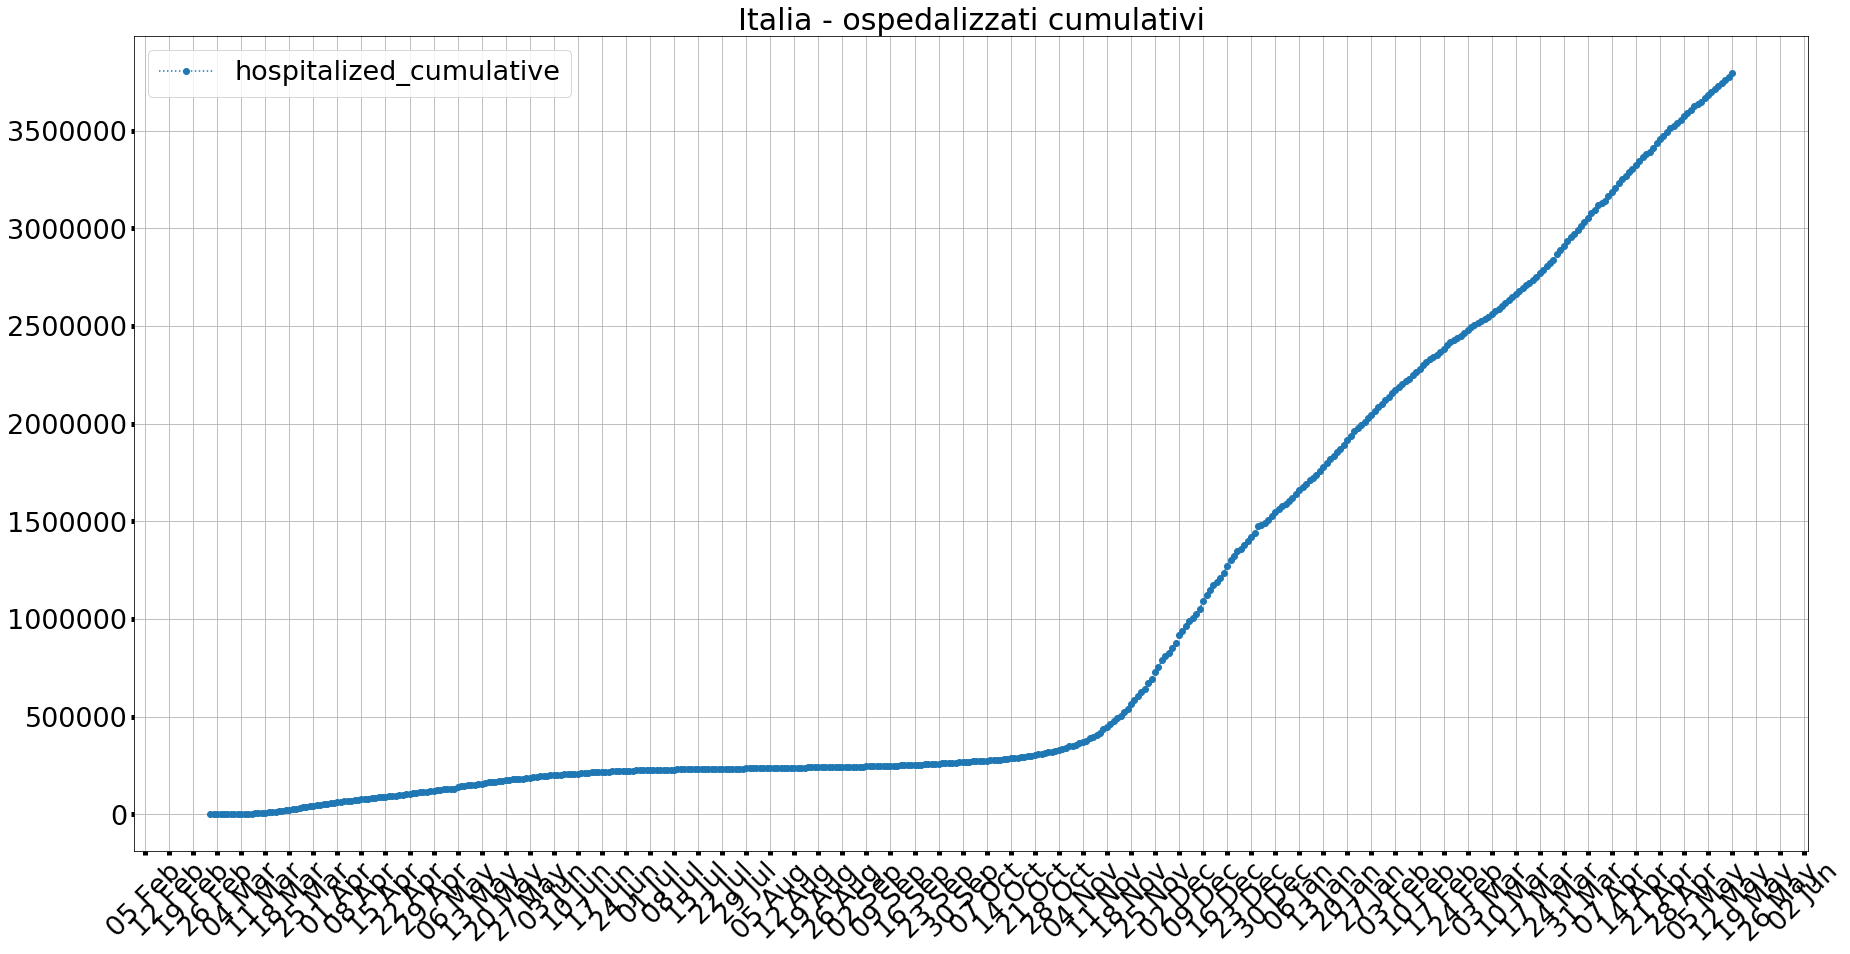

In [39]:
plot_series(
    'Italia - ospedalizzati cumulativi',    
    italy_raw_data, 
    [
        'hospitalized_cumulative',
    ],
)

# compute new hospitalized via Tikhonov

In [40]:
italy_raw_data['new_hospitalilzed'] = smooth_differentiate(
    italy_raw_data.hospitalized_cumulative,
    X=INTEGRAL_MATRIX,
    L=GAMMA,
    alpha=ALPHA
)

TIC R2: 0.9999957349047807


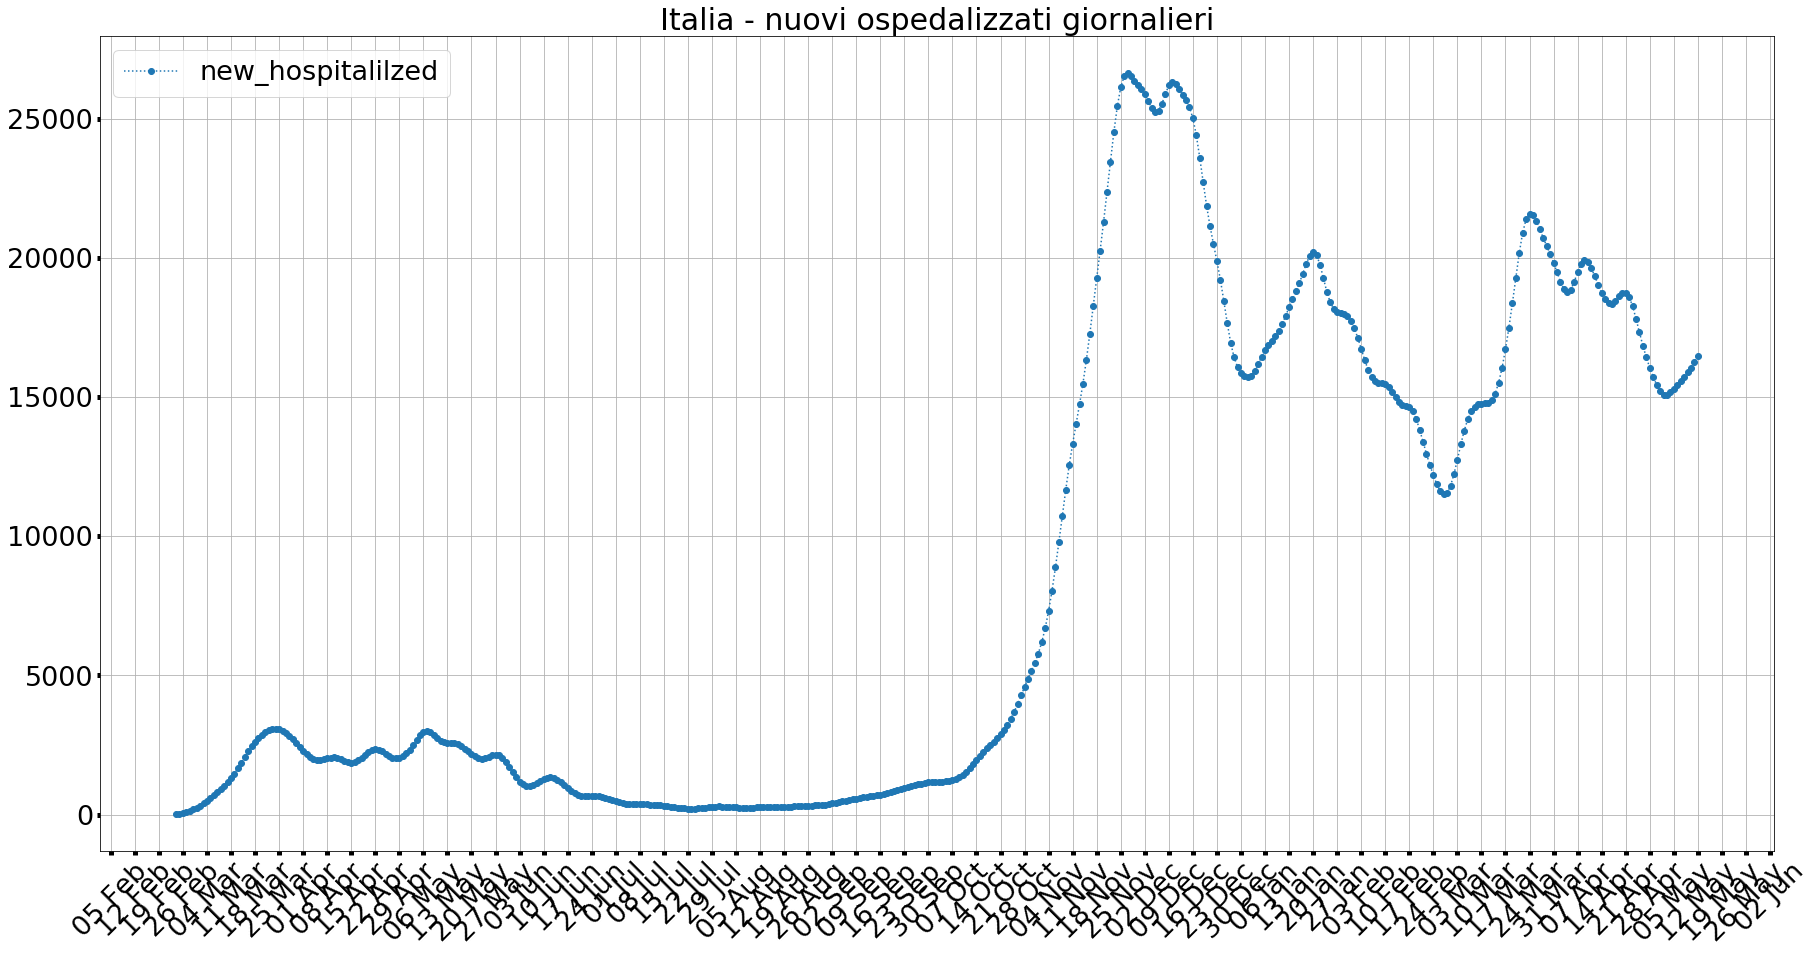

In [41]:
plot_series(
    'Italia - nuovi ospedalizzati giornalieri',
    italy_raw_data, 
    [
        'new_hospitalilzed',
    ],
)

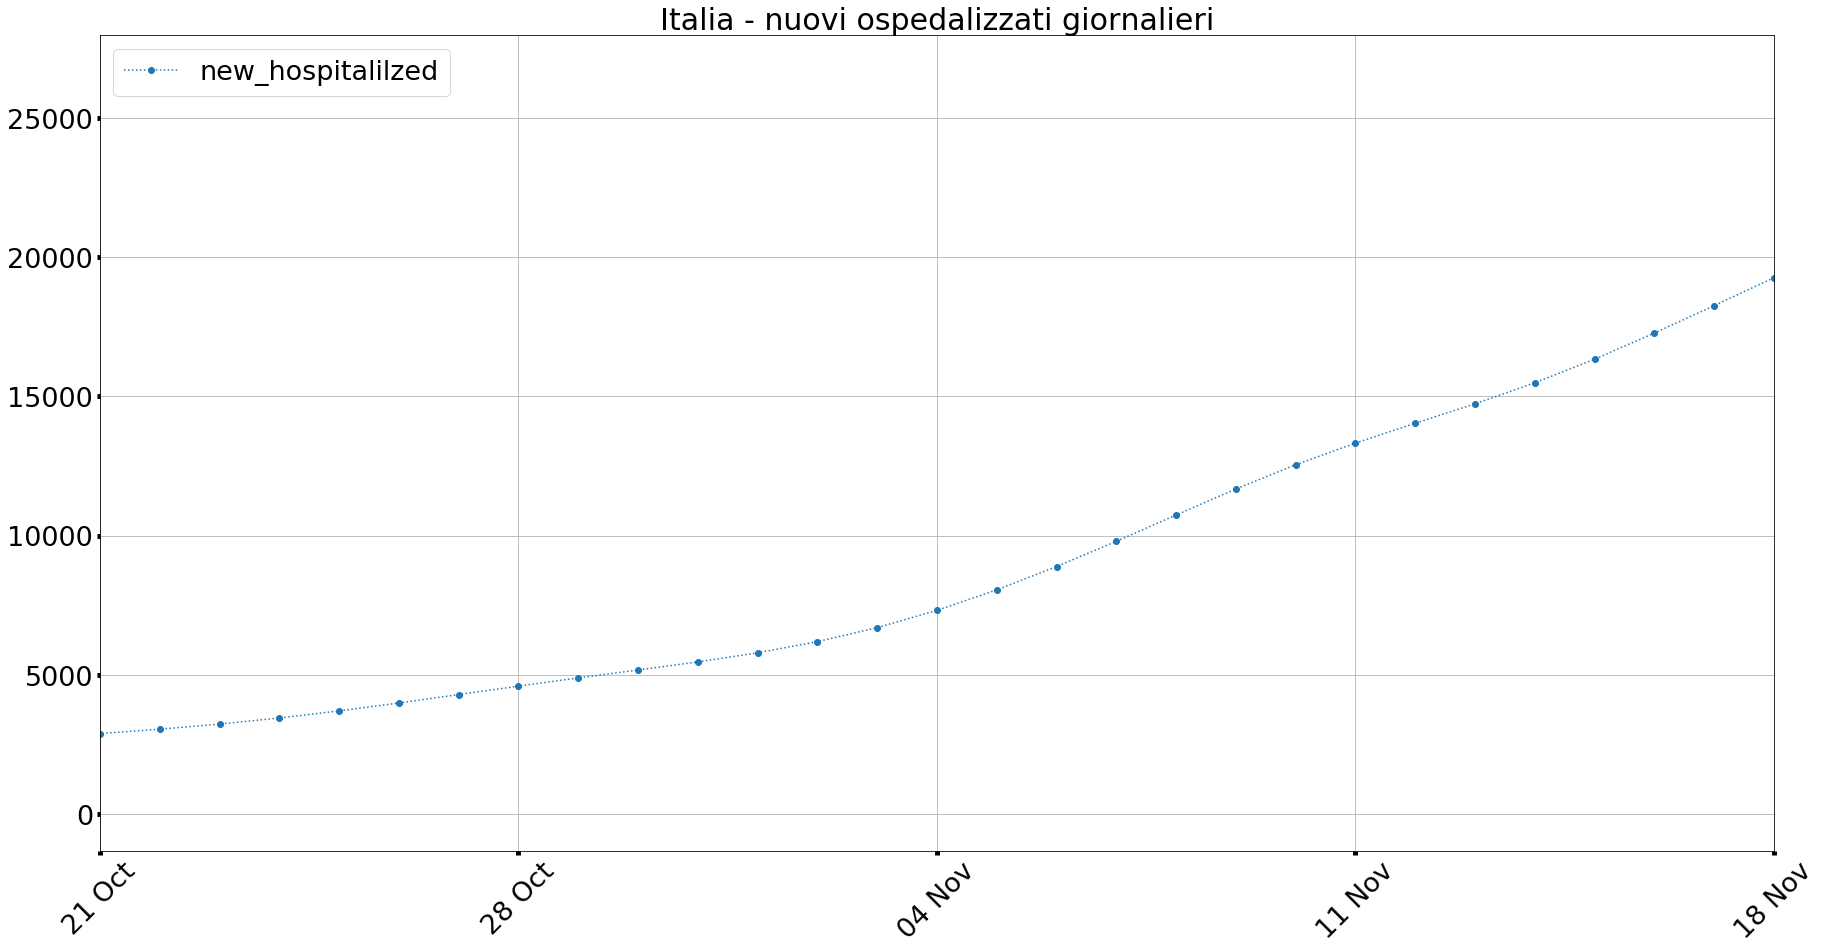

In [42]:
plot_series(
    'Italia - nuovi ospedalizzati giornalieri',
    italy_raw_data, 
    [
        'new_hospitalilzed',
    ],
    xlim=(datetime(2020,10,21),datetime(2020,11,18))
)

# Compute the $R_t$ based on the new hospitalized with uncertainty

## Sample $R_t$ distribution on `new_hospitalized` smoothed series

In [43]:
alpha = 1.87
beta = 0.28

In [44]:
possibile_smoothed_new_hospitalized = compute_and_store_differences_with_uncertainty(
    df=italy_raw_data,
    cumulative_in='hospitalized_cumulative', difference_out='new_hospitalized_smoothed_uncertainty',
    alpha=alpha, beta=beta,
    future_distribution = 'normal', tune=5000, draws=25, target_accept=0.99, chains=1)

15967.0


Only 25 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [derivative]


Sampling 1 chain for 5_000 tune and 25 draw iterations (5_000 + 25 draws total) took 6 seconds.


possibile_smoothed_differences: (25, 444)


In [45]:
simulations_nh = []
for i in range(possibile_smoothed_new_hospitalized.shape[0]):
    model_, trace_ = MCMC_sample(
        onset=possibile_smoothed_new_hospitalized[i],
        alpha=alpha, beta=beta,
        start=0, window=None,
        chains=4,
        tune=500,
        draws=100,
        dry=False,
        progressbar=False
    )
    simulations_nh.append(trace_)
    
sampled_Rt_nh = np.array([t['r_t'] for t in simulations_nh])
combined_trace_nh = {'r_t': sampled_Rt_nh.reshape((-1,sampled_Rt_nh.shape[2]))}

Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [r_t]
Sampling 4 chains for 500 tune and 100 draw iterations (2_000 + 400 draws total) took 7 seconds.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [r_t]
Sampling 4 chains for 500 tune and 100 draw iterations (2_000 + 400 draws total) took 9 seconds.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [r_t]
Sampling 4 chains for 500 tune and 100 draw iterations (2_000 + 400 draws total) took 9 seconds.
The rhat statistic 

The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [r_t]
Sampling 4 chains for 500 tune and 100 draw iterations (2_000 + 400 draws total) took 8 seconds.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [r_t]
Sampling 4 chains for 500 tune and 100 draw iterations (2_000 + 400 draws total) took 8 seconds.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.


In [46]:
save_MCMC_sampling(
    italy_raw_data, 
    'new_hospitalized_smoothed', 
    combined_trace_nh, 
    start=0, window=None
)

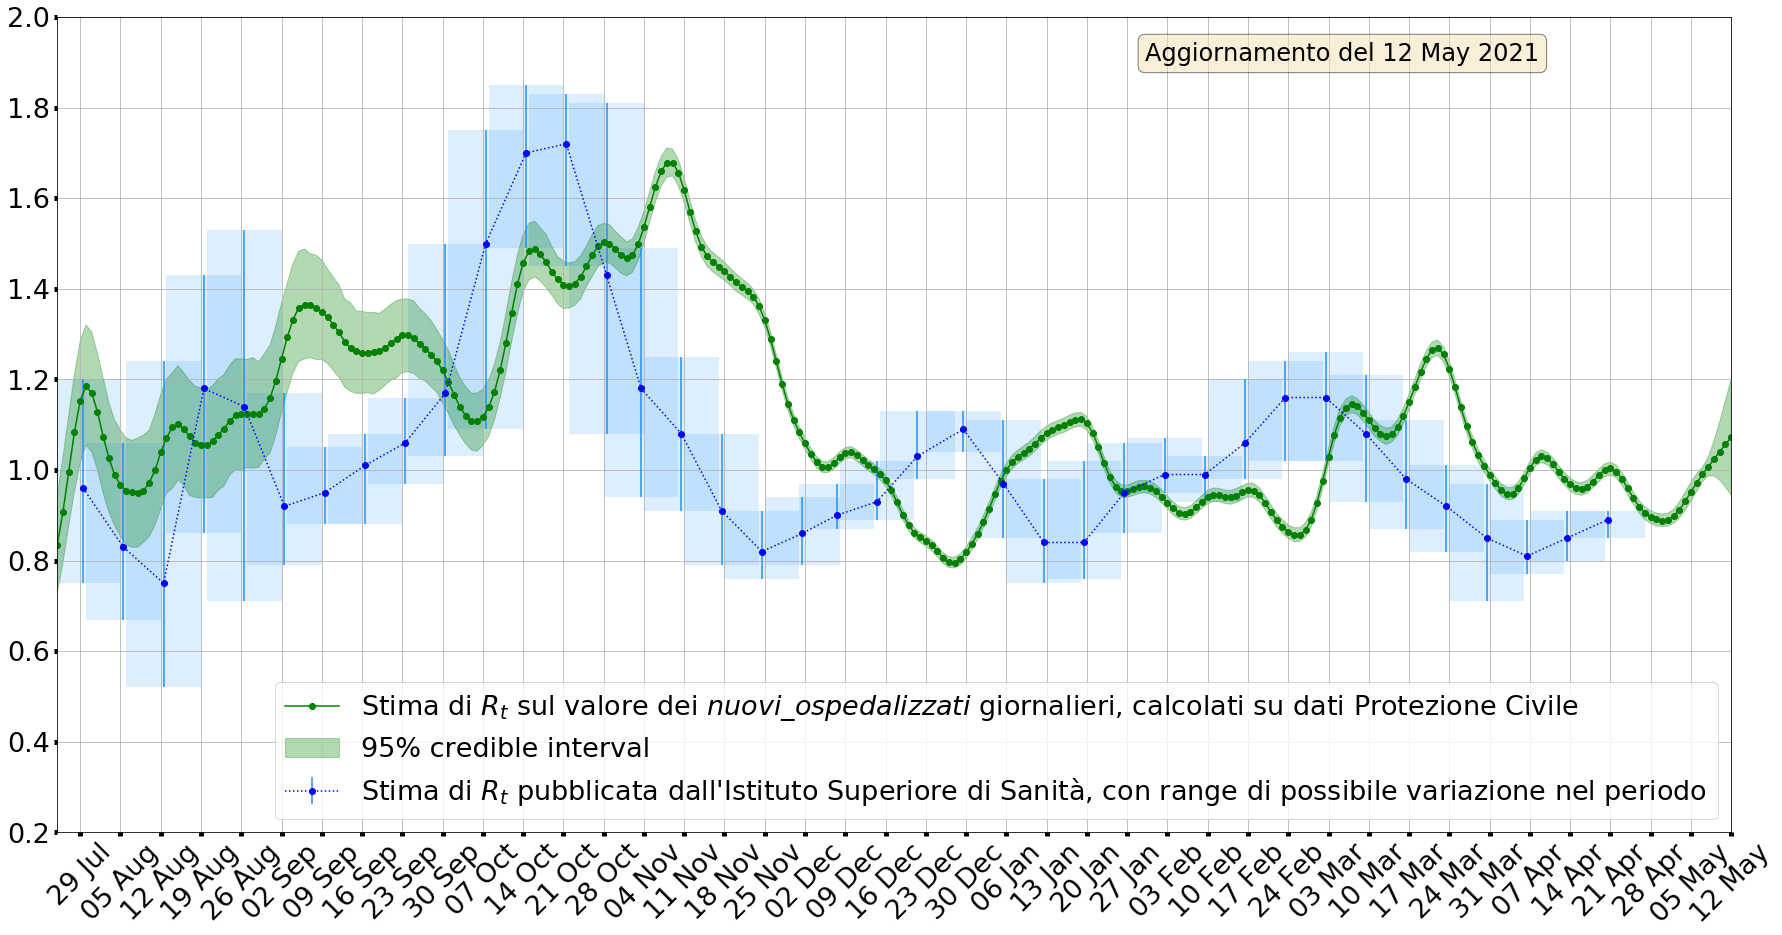

In [47]:
plot_MCMC_sampling(
    italy_raw_data, 
    'new_hospitalized_smoothed', 
    ISS_Rt_clean,
    xlim=(datetime(2020,7,25),italy_raw_data.data.dt.normalize().max()), 
    std=False, 
    average=False, 
    ylim=(0.2,2),
    path=SAVE_IMAGE_PATH,
    dpi=150
)